<a href="https://colab.research.google.com/github/Fall2024CS584/Lectures/blob/main/Linear_Discriminant_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Discriminant Analysis

Let $Y$ denote the outcome of a $K$ class classifier. Looking to estimate:
$$
P(Y = k | X = x)
$$

or $P(Y|X)$ for short. Let $f_k(x)$ denote the class-conditional density function of $X$.
$$
f_k(x) = P(X = x | Y = k)
$$

From Bayes' Rule, we get
$$
P(Y=k|X=x) = \frac{f_k(x) \pi_k}{\sum_{j=1}^K f_j(x) \pi_j}
$$

where $\pi_k = P(Y = k)$.

So we can decide classes if we can compute the $f_k(x)$. Assume the $f_k(x)$ are (multivariate) normal variables.

If we compare two classes $k$ and $j$, we can look at the log-probability ratio

\begin{align*}
\log \frac{P(Y = k | X= x)}{P(Y=j | X = x)} &= \log \frac{f_k(x)}{f_j(x)} + \log \frac{\pi_k}{\pi_j} \\
&= -\frac{1}{2} \langle(\mu_k - \mu_j), \Sigma^{-1} (\mu_k - \mu_j) \rangle + \langle x, \Sigma^{-1} (\mu_k - \mu_j)\rangle + \log \frac{\pi_k}{\pi_j}
\end{align*}

For LDA, we assume that the covariance is common to all classes.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (20, 10)

In [ ]:
def generate_classifier_data(c_1, c_2, c_3, sigma, size_1, size_2, size_3, seed):
  rng = numpy.random.default_rng(seed=seed)
  class1 = rng.multivariate_normal(c_1, sigma, size=size_1)
  class2 = rng.multivariate_normal(c_2, sigma, size=size_2)
  class3 = rng.multivariate_normal(c_3, sigma, size=size_3)
  ys1 = numpy.ones(shape=(class1.shape[0],1))
  ys2 = numpy.zeros(shape=(class2.shape[0], 1))
  ys3 = 2*numpy.ones(shape=(class3.shape[0],1))
  xs = numpy.vstack((class1, class2, class3))
  ys = numpy.vstack((ys1, ys2, ys3))
  return (xs, ys)


In [ ]:
c_1 = numpy.array([1, -1, 1])
c_2 = numpy.array([-1, 1, 2])
c_3 = numpy.array([-1, -1, -1])
sigma_12 = numpy.array([[0.5, 0.3, 0.1], [-0.2, 0.7, 0.2], [-0.4, 0.5, -0.6]])
sigma = numpy.matmul(sigma_12.T, sigma_12)#numpy.array([[1, 0], [0, 1]])
xs, ys = generate_classifier_data(c_1, c_2,c_3, sigma, 500, 50, 150, 8675309)

In [ ]:
xs.shape

(700, 3)

In [ ]:
ys.shape

(700, 1)

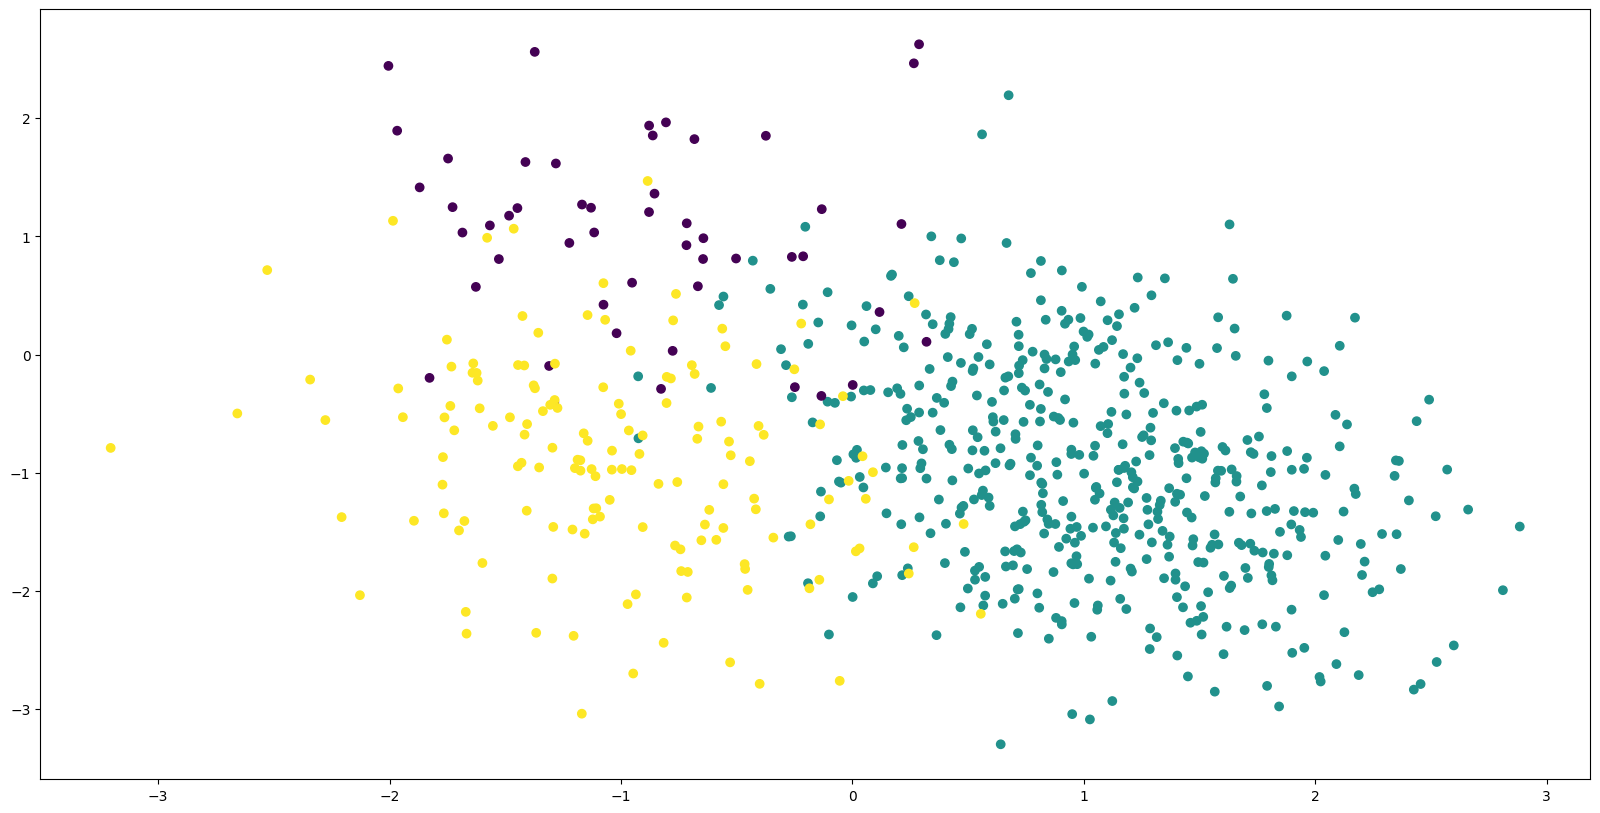

In [ ]:
ax1 = plt.scatter(xs[:,0], xs[:,1], c=ys)

In [ ]:
class LDAClassifier():
  def __init__(self):
    pass

  def fit(self, xs, ys):
    n_0 = numpy.where(ys==0.0)[0].shape[0]
    n_1 = numpy.where(ys==1.0)[0].shape[0]
    x_0 = xs[numpy.where(ys == 0.0)[0],:]
    x_1 = xs[numpy.where(ys == 1.0)[0], :]
    self.mu_0 = numpy.mean(x_0, axis=0)
    self.mu_1 = numpy.mean(x_1, axis=0)
    sigma_0 = 1/(n_0 - 1)*numpy.matmul((x_0 - self.mu_0).T, x_0 - self.mu_0)
    sigma_1 = 1/(n_1 - 1)*numpy.matmul((x_1 - self.mu_1).T, x_1 - self.mu_1)
    self.pi_0 = n_0/(n_1 + n_0)
    self.pi_1 = n_0/(n_1 + n_0)
    self.sigma = (sigma_0 + sigma_1)/2
    return LDAClassifierResult(self.pi_0,
                               self.pi_1,
                               self.mu_0,
                               self.mu_1,
                               self.sigma)

class LDAClassifierResult():
  def __init__(self, pi_0, pi_1, mu_0, mu_1, sigma):
    self.pi_0 = pi_0
    self.pi_1 = pi_1
    self.mu_0 = mu_0
    self.mu_1 = mu_1
    self.sigma = sigma

  def predict(self, x):
    LL = self._log_loss(x)
    exp_ll = numpy.exp(LL)
    return (exp_ll/(exp_ll + 1), 1/(exp_ll + 1))


  def viz_everything(self):
    sigma_inv = numpy.linalg.inv(self.sigma)
    x_hat = numpy.matmul(sigma_inv, self.mu_0 - self.mu_1)
    offset = numpy.log(self.pi_1/self.pi_0) + 1/2*numpy.log(numpy.linalg.det(self.sigma)*2*numpy.pi)
    slope = -1*x_hat[0]/x_hat[1]
    intercept = offset/x_hat[1]
    t = numpy.arange(-2, 2, 0.1)
    return (t, slope*t + intercept)

  def _log_loss(self, x):
    sigma_inv = numpy.linalg.inv(self.sigma)
    sigma_inv_dist = numpy.matmul(sigma_inv, self.mu_0 - self.mu_1)
    first_term = -1/2*numpy.matmul(self.mu_0 + self.mu_1, sigma_inv_dist)
    second_term = numpy.matmul(x, sigma_inv_dist)
    third_term = numpy.log(self.pi_0/self.pi_1)
    const = -1/2*numpy.log(numpy.linalg.det(self.sigma)*2*numpy.pi)
    return first_term + second_term + third_term + const

In [ ]:
model = LDAClassifier()

In [ ]:
result = model.fit(xs, ys)

In [ ]:
result.predict(numpy.array([-1, 1, 1]))

(0.9985030039676435, 0.0014969960323565899)

In [ ]:
t, line = result.viz_everything()

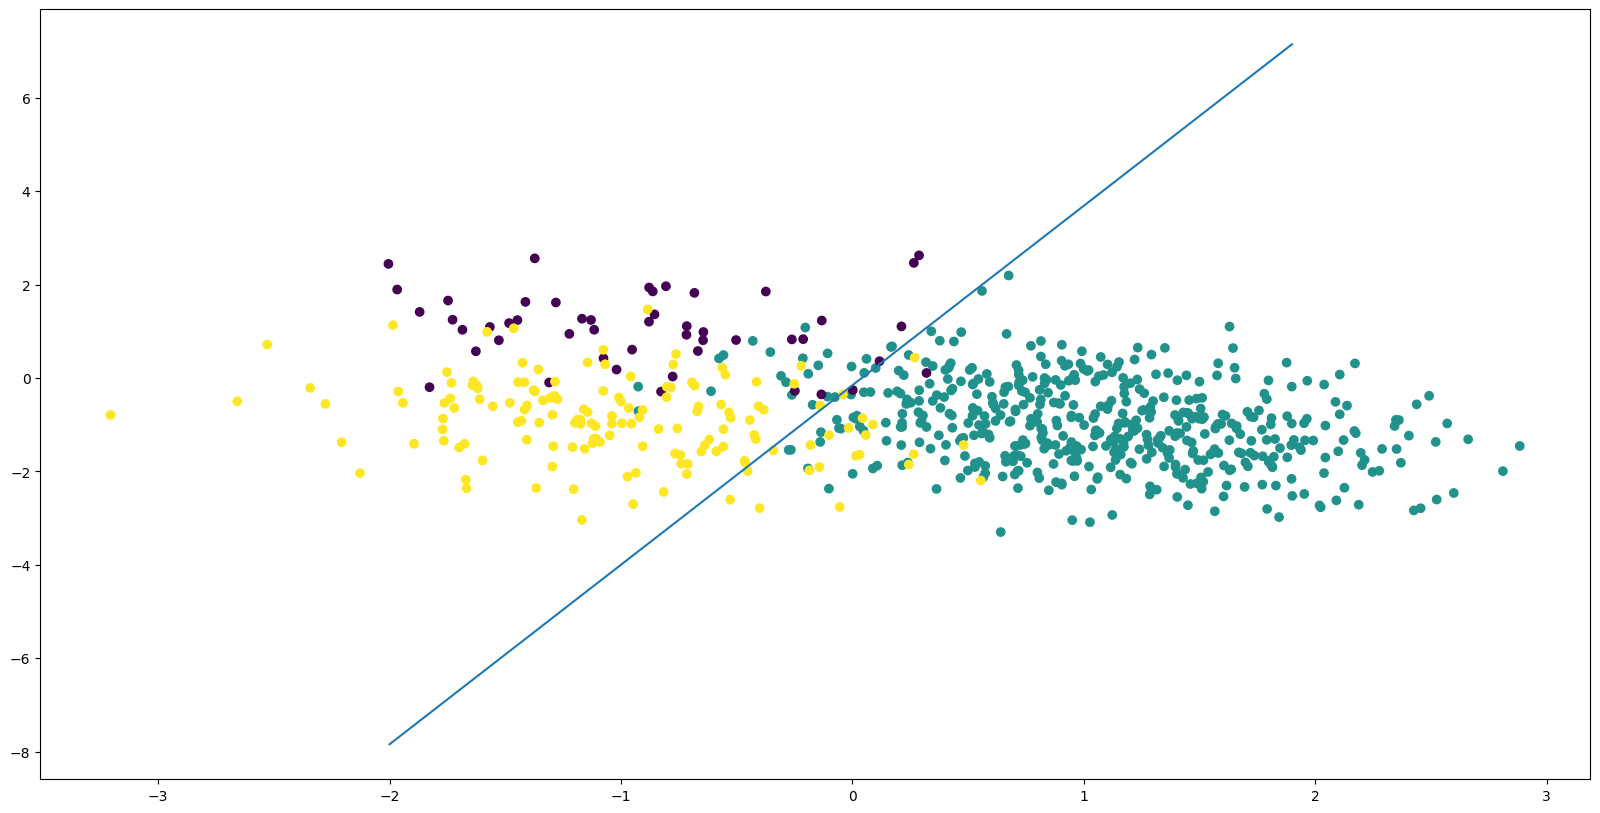

In [ ]:
plt.plot(t, line)
plt.scatter(xs[:,0], xs[:,1], c=ys)

In [ ]:
numpy.linalg.inv(sigma)

array([[ 3.54589711,  0.49778518, -2.00429806],
       [ 0.49778518,  1.33766063,  0.12060875],
       [-2.00429806,  0.12060875,  3.69939915]])

# Supervised Dimensionality Reduction

In [ ]:
def generate_classifier_data(rnge, k, d, sizes, seed):


    rng = numpy.random.default_rng(seed=seed)
    cs = rng.uniform(rnge[0], rnge[1], size=(k, d))
    mb = rng.normal(loc=0, scale=.3, size=(k,d))
    noise = rng.normal(loc=0, scale=0.01, size=(d,d))
    sigma_signal = numpy.matmul(mb.T, mb)
    noisy_sigma = sigma_signal + noise
    sigma = numpy.matmul(noisy_sigma.T, noisy_sigma)
    classes = [rng.multivariate_normal(c, sigma, size=size) for c, size in zip(cs,sizes)]
    ys = [j*numpy.ones(shape=(size, 1)) for j, size in enumerate(sizes)]
    xs = numpy.vstack(classes)
    ys = numpy.vstack(ys)
    return (xs, ys)


In [ ]:
rnge = [-10,10]
k = 2
d = 300
sizes = [5000, 1000]
X, y = generate_classifier_data(rnge, k, d, sizes, 8675309)
X.shape

(6000, 300)

In [ ]:
model = LDAClassifier()
result = model.fit(X,y)

In [ ]:
inv_sigma = numpy.linalg.inv(result.sigma)
p = numpy.linalg.eig(inv_sigma)[1][:,-2:]

In [ ]:
numpy.matmul(p.T, p)

array([[ 1.00000000e+00, -1.52832629e-09],
       [-1.52832629e-09,  1.00000000e+00]])

In [ ]:
numpy.linalg.eigvals(result.sigma)

array([8.89098193e+02, 4.14578673e+02, 1.19911074e-01, 1.18929913e-01,
       1.17764279e-01, 1.14877199e-01, 1.12658100e-01, 1.10366718e-01,
       1.08847399e-01, 1.07695227e-01, 1.05034059e-01, 1.04605961e-01,
       1.02161916e-01, 1.00718570e-01, 9.99692501e-02, 9.92323896e-02,
       9.64558546e-02, 9.46659125e-02, 9.30016300e-02, 9.26934546e-02,
       9.11693387e-02, 9.05542771e-02, 8.91255752e-02, 8.80698397e-02,
       8.58493859e-02, 8.55453494e-02, 8.43794707e-02, 8.38010149e-02,
       7.85298366e-02, 8.29230608e-02, 8.22677460e-02, 7.99272537e-02,
       8.12491548e-02, 8.08568985e-02, 7.77275985e-02, 7.70894933e-02,
       7.53053482e-02, 7.38570589e-02, 7.33868238e-02, 7.24729805e-02,
       7.13079599e-02, 7.10945003e-02, 7.02226503e-02, 6.88204799e-02,
       6.85723877e-02, 6.78049226e-02, 6.67369458e-02, 6.62562174e-02,
       6.25092284e-02, 6.31683744e-02, 6.37724432e-02, 6.47794191e-02,
       6.44889965e-02, 6.21032516e-02, 6.12904375e-02, 5.94534546e-02,
      

In [ ]:
X_p = numpy.matmul(X, p)

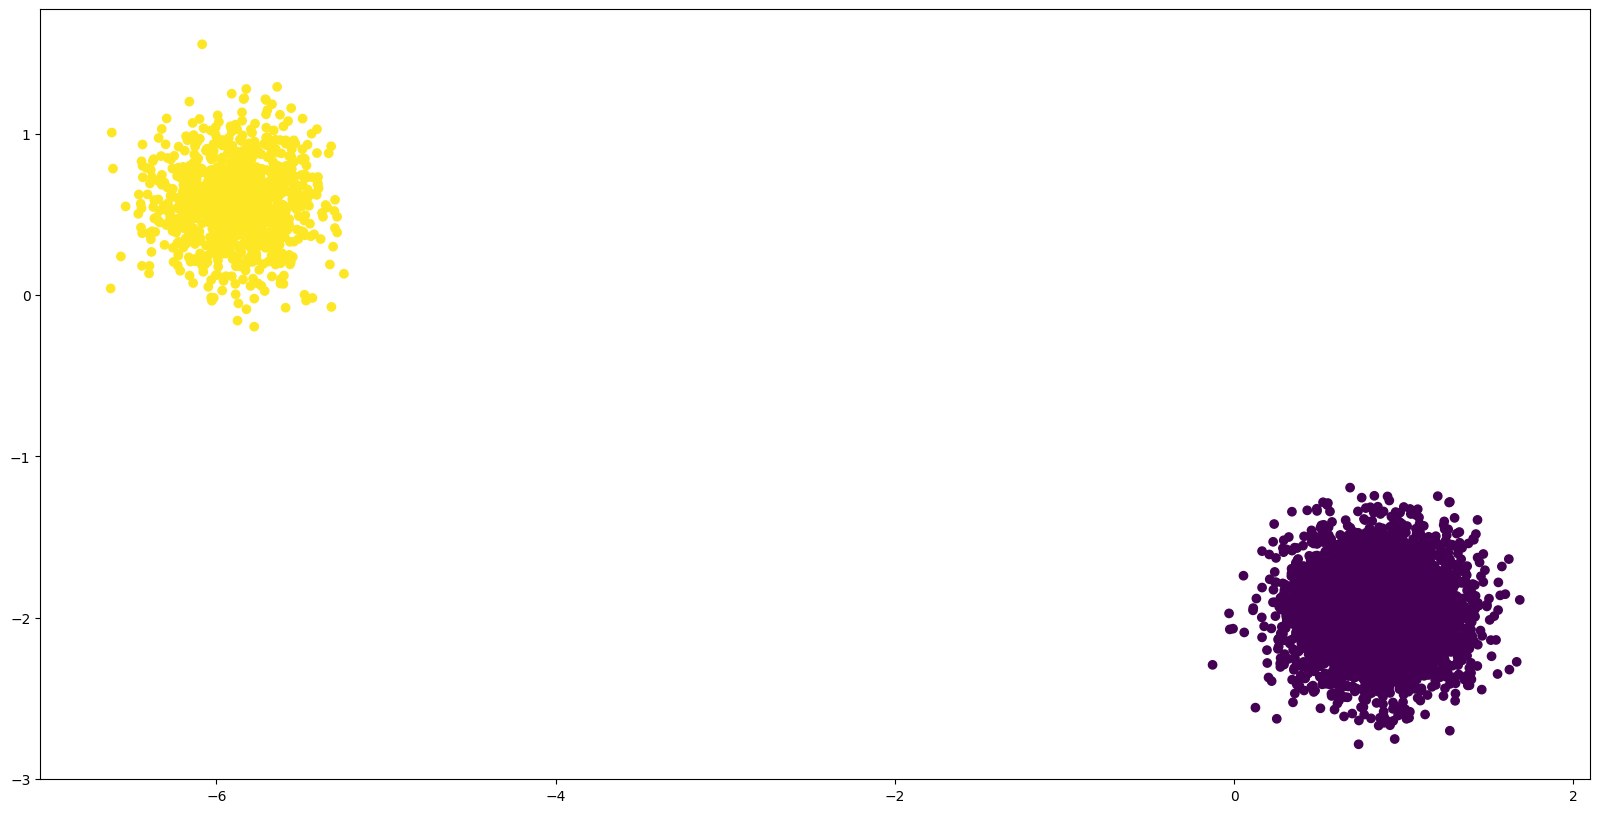

In [ ]:
plt.scatter(X_p[:,0], X_p[:,1], c=y)
plt.show()